Simulate methods for interaction coding.

In [1]:
import numpy
import matplotlib.pyplot as plt
import scipy.stats

%matplotlib inline



In [2]:
# setup HRF

def spm_hrf(TR,p=[6,16,1,1,6,0,32]):
    """ An implementation of spm_hrf.m from the SPM distribution

Arguments:

Required:
TR: repetition time at which to generate the HRF (in seconds)

Optional:
p: list with parameters of the two gamma functions:
                                                     defaults
                                                    (seconds)
   p[0] - delay of response (relative to onset)         6
   p[1] - delay of undershoot (relative to onset)      16
   p[2] - dispersion of response                        1
   p[3] - dispersion of undershoot                      1
   p[4] - ratio of response to undershoot               6
   p[5] - onset (seconds)                               0
   p[6] - length of kernel (seconds)                   32

"""

    p=[float(x) for x in p]

    fMRI_T = 16.0

    TR=float(TR)
    dt  = TR/fMRI_T
    u   = numpy.arange(p[6]/dt + 1) - p[5]/dt
    hrf=scipy.stats.gamma.pdf(u,p[0]/p[2],scale=1.0/(dt/p[2])) - scipy.stats.gamma.pdf(u,p[1]/p[3],scale=1.0/(dt/p[3]))/p[4]
    good_pts=numpy.array(range(numpy.int(p[6]/TR)))*fMRI_T
    hrf=hrf[list(good_pts.astype('int'))]
    # hrf = hrf([0:(p(7)/RT)]*fMRI_T + 1);
    hrf = hrf/numpy.sum(hrf);
    return hrf


Text(0.5, 1.0, '-(B - task) (congruent)')

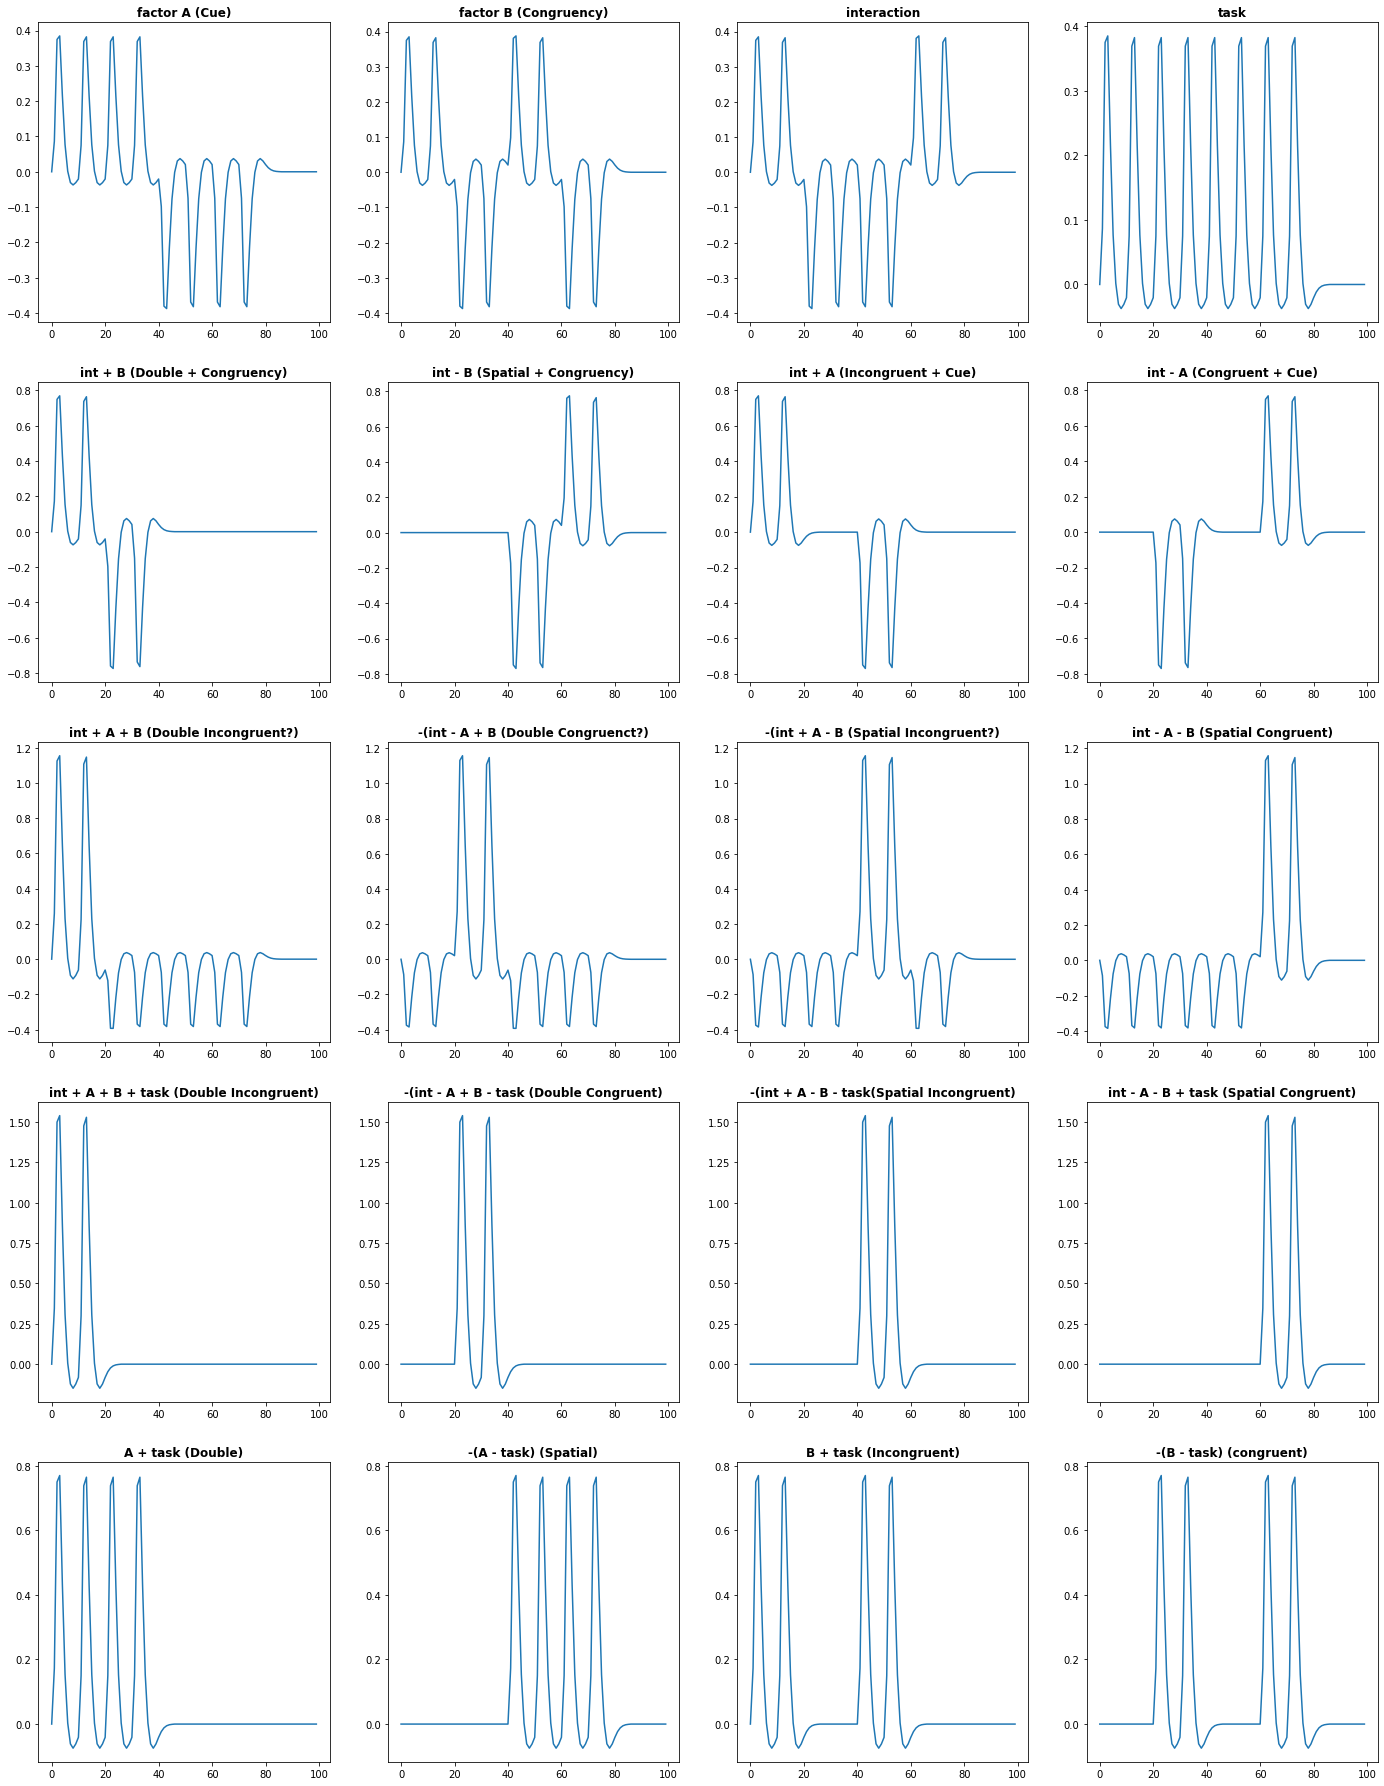

In [70]:
# create design matrix two orthogonal factors and interaction


A = numpy.array([1, 1, 1, 1, -1, -1, -1, -1])
B = numpy.array([1, 1, -1, -1, 1, 1, -1, -1])
interaction = A * B

task=numpy.array([1, 1, 1, 1, 1, 1, 1, 1])

tslength = 100 # added by HJ (based on default value fed into generate_conv_ts below)


def generate_conv_ts(trial_params,
                     tslength = 100,
                     spacing = 10):
    """generate convolved timeseries
    from trial responses"""
    ts = numpy.zeros(tslength)
    for i in range(trial_params.shape[0]):
        tp = i * spacing
        ts[tp] = trial_params[i]
    ts_conv = numpy.convolve(ts, spm_hrf(2))[:tslength]
    return(ts_conv)

    
def estimate_params(y, X):
    beta_hat = numpy.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
    return(beta_hat)

X_conv = numpy.zeros((tslength, 5))

X_conv[:, 0] = generate_conv_ts(A)
X_conv[:, 1] = generate_conv_ts(B)
X_conv[:, 2] = generate_conv_ts(interaction)
X_conv[:, 3] = numpy.ones(tslength)
X_conv[:, 4] = generate_conv_ts(task)

    
beta = numpy.array([1,1,1])

plt.figure(figsize = (24,32))

#ROW 1 - PLOTTING MAIN REGRESSORS
plt.subplot(541)
plt.plot(X_conv[:, 0])
plt.title('factor A (Cue)',fontweight='bold')

plt.subplot(542)
plt.plot(X_conv[:, 1])
plt.title('factor B (Congruency)',fontweight='bold')

plt.subplot(543)
plt.plot(X_conv[:, 2])
plt.title('interaction',fontweight='bold')

plt.subplot(544)
plt.plot(X_conv[:, 4])
plt.title('task',fontweight='bold')

#ROW 2 - PLAYING WITH INTERACTIONS
plt.subplot(545)
plt.plot(X_conv[:, 2]+X_conv[:,1])
plt.title('int + B (Double + Congruency)',fontweight='bold')

plt.subplot(546)
plt.plot(X_conv[:, 2]-X_conv[:,1])
plt.title('int - B (Spatial + Congruency)',fontweight='bold')

plt.subplot(547)
plt.plot(X_conv[:, 2]+X_conv[:,0])
plt.title('int + A (Incongruent + Cue)',fontweight='bold')

plt.subplot(548)
plt.plot(X_conv[:, 2]-X_conv[:,0])
plt.title('int - A (Congruent + Cue)',fontweight='bold')

#ROW 3 - TRYING TO ISOLATE SPECIFIC TRIAL TYPES
plt.subplot(5,4,9)
plt.plot(X_conv[:, 2]+X_conv[:,0]+X_conv[:,1])
plt.title('int + A + B (Double Incongruent?)',fontweight='bold')

plt.subplot(5,4,10)
plt.plot(-(X_conv[:, 2]-X_conv[:,0]+X_conv[:,1]))
plt.title('-(int - A + B (Double Congruenct?)',fontweight='bold')

plt.subplot(5,4,11)
plt.plot(-(X_conv[:, 2]+X_conv[:,0]-X_conv[:,1]))
plt.title('-(int + A - B (Spatial Incongruent?)',fontweight='bold')

plt.subplot(5,4,12)
plt.plot(X_conv[:, 2]-X_conv[:,0]-X_conv[:,1])
plt.title('int - A - B (Spatial Congruent)',fontweight='bold')

#ROW 4 - USING TASK REGRESSOR TO ISOLATE SPECIFIC TRIAL TYPES?
plt.subplot(5,4,13)
plt.plot(X_conv[:, 2]+X_conv[:,0]+X_conv[:,1]+X_conv[:,4])
plt.title('int + A + B + task (Double Incongruent)',fontweight='bold')

plt.subplot(5,4,14)
plt.plot(-(X_conv[:, 2]-X_conv[:,0]+X_conv[:,1]-X_conv[:,4]))
plt.title('-(int - A + B - task (Double Congruent)',fontweight='bold')

plt.subplot(5,4,15)
plt.plot(-(X_conv[:, 2]+X_conv[:,0]-X_conv[:,1]-X_conv[:,4]))
plt.title('-(int + A - B - task(Spatial Incongruent)',fontweight='bold')

plt.subplot(5,4,16)
plt.plot(X_conv[:, 2]-X_conv[:,0]-X_conv[:,1]+X_conv[:,4])
plt.title('int - A - B + task (Spatial Congruent)',fontweight='bold')

#ROW 5 - USING TASK REGRESSOR TO ISOLATE CONDITIONS
plt.subplot(5,4,17)
plt.plot(X_conv[:,0]+X_conv[:,4])
plt.title('A + task (Double)',fontweight='bold')

plt.subplot(5,4,18)
plt.plot(-(X_conv[:,0]-X_conv[:,4]))
plt.title('-(A - task) (Spatial)',fontweight='bold')

plt.subplot(5,4,19)
plt.plot(X_conv[:,1]+X_conv[:,4])
plt.title('B + task (Incongruent)',fontweight='bold')

plt.subplot(5,4,20)
plt.plot(-(X_conv[:,1]-X_conv[:,4]))
plt.title('-(B - task) (congruent)',fontweight='bold')

## Create some data reflecting various situations and look at parameter estimates.

Text(0, 0.5, 'parameter estimate')

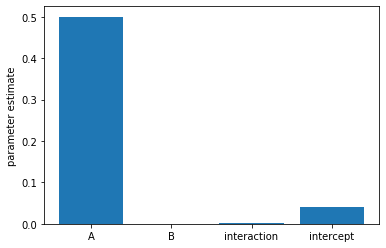

In [31]:
# effect of A only

trial_resp =  numpy.array([1, 1, 1, 1, 0, 0, 0, 0])
ts = generate_conv_ts(trial_resp)
beta_hat = estimate_params(ts,X_conv)
plt.bar(x = ['A', 'B', 'interaction', 'intercept'], height=beta_hat)
plt.ylabel('parameter estimate')

Text(0, 0.5, 'parameter estimate')

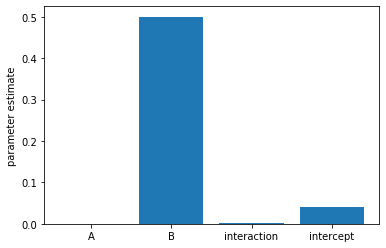

In [32]:
# effect of B only

trial_resp =  numpy.array([1, 1, 0, 0, 1, 1, 0, 0])
ts = generate_conv_ts(trial_resp)
beta_hat = estimate_params(ts,X_conv)
plt.bar(x = ['A', 'B', 'interaction', 'intercept'], height=beta_hat)
plt.ylabel('parameter estimate')

Text(0, 0.5, 'parameter estimate')

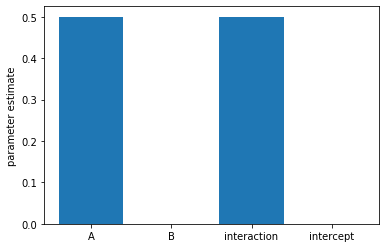

In [33]:
# interaction - effect of A only when B is positive

trial_resp =  numpy.array([1, 1, 0, 0, -1, -1, 0, 0])
ts = generate_conv_ts(trial_resp)
beta_hat = estimate_params(ts,X_conv)
plt.bar(x = ['A', 'B', 'interaction', 'intercept'], height=beta_hat)
plt.ylabel('parameter estimate')

Text(0, 0.5, 'parameter estimate')

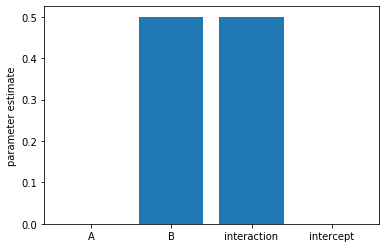

In [34]:
# interaction - effect of B only when A is positive

trial_resp =  numpy.array([1, 1, -1, -1, 0, 0, 0, 0])
ts = generate_conv_ts(trial_resp)
beta_hat = estimate_params(ts,X_conv)
plt.bar(x = ['A', 'B', 'interaction', 'intercept'], height=beta_hat)
plt.ylabel('parameter estimate')

Text(0, 0.5, 'parameter estimate')

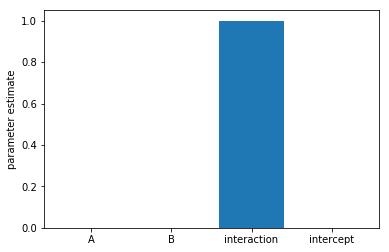

In [67]:
# interaction - effect of B reversed under A (full disordinal interaction)

trial_resp =  numpy.array([1,  1, -1, -1, -1, -1,  1,  1])
ts = generate_conv_ts(trial_resp)
beta_hat = estimate_params(ts,X_conv)
plt.bar(x = ['A', 'B', 'interaction', 'intercept'], height=beta_hat)
plt.ylabel('parameter estimate')